In [1]:
# Libraries for general purpose
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Text cleaning
import re
import string
import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords

# Data preprocessing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from nltk.tokenize import word_tokenize

# PyTorch LSTM
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Tokenization for LSTM
from collections import Counter
from gensim.models import Word2Vec

from sklearn.metrics import classification_report, confusion_matrix

import time

# Set seed for reproducibility
import random
seed_value = 2042
random.seed(seed_value)
np.random.seed(seed_value)
#torch.manual_seed(seed_value)
#torch.cuda.manual_seed_all(seed_value)

# Set style for plots
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)

# Define stop words for text cleaning
stop_words = set(stopwords.words('english'))

# Initialize lemmatizer for text cleaning
lemmatizer = WordNetLemmatizer()

C:\Users\abdul\AppData\Local\Temp\ipykernel_2056\1924078304.py:46: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


<Figure size 640x480 with 0 Axes>

In [2]:
df = pd.read_csv("sentiment-emotion-labelled_Dell_tweets.csv")
df

,Unnamed: 0,Datetime,Tweet Id,Text,Username,sentiment,sentiment_score,emotion,emotion_score
0,0,2022-09-30 23:29:15+00:00,1.575990e+18,@Logitech @apple @Google @Microsoft @Dell @Len...,ManjuSreedaran,neutral,0.853283,anticipation,0.587121
1,1,2022-09-30 21:46:35+00:00,1.575970e+18,@MK_habit_addict @official_stier @MortalKombat...,MiKeMcDnet,neutral,0.519470,joy,0.886913
2,2,2022-09-30 21:18:02+00:00,1.575960e+18,"As @CRN celebrates its 40th anniversary, Bob F...",jfollett,positive,0.763791,joy,0.960347
3,3,2022-09-30 20:05:24+00:00,1.575940e+18,@dell your customer service is horrible especi...,daveccarr,negative,0.954023,anger,0.983203
4,4,2022-09-30 20:03:17+00:00,1.575940e+18,@zacokalo @Dell @DellCares @Dell give the man ...,heycamella,neutral,0.529170,anger,0.776124
...,...,...,...,...,...,...,...,...,...
24965,24965,2022-01-01 02:02:04+00:00,1.477100e+18,@ElDarkAngel2 @GamersNexus @Dell I wouldn't ev...,Eodart,negative,0.682981,anger,0.906309
24966,24966,2022-01-01 01:57:34+00:00,1.477100e+18,@kite_real @GamersNexus @Dell I didn't really ...,Eodart,positive,0.743940,joy,0.951701
24967,24967,2022-01-01 01:36:36+00:00,1.477090e+18,Hey @JoshTheFixer here it is....27 4K UHD USB-...,Corleone250,neutral,0.654463,anticipation,0.471185
24968,24968,2022-01-01 01:31:30+00:00,1.477090e+18,@bravadogaming @thewolfpena @Alienware @intel ...,MrTwistyyy,neutral,0.794049,anticipation,0.747014


In [3]:
data = df[['Text','emotion']]
df=data
df

,Text,emotion
0,@Logitech @apple @Google @Microsoft @Dell @Len...,anticipation
1,@MK_habit_addict @official_stier @MortalKombat...,joy
2,"As @CRN celebrates its 40th anniversary, Bob F...",joy
3,@dell your customer service is horrible especi...,anger
4,@zacokalo @Dell @DellCares @Dell give the man ...,anger
...,...,...
24965,@ElDarkAngel2 @GamersNexus @Dell I wouldn't ev...,anger
24966,@kite_real @GamersNexus @Dell I didn't really ...,joy
24967,Hey @JoshTheFixer here it is....27 4K UHD USB-...,anticipation
24968,@bravadogaming @thewolfpena @Alienware @intel ...,anticipation


In [4]:
df = df.rename(columns={'Text': 'text','emotion': 'sentiment'})

In [5]:
#dropping duplicate tweets

df.duplicated().sum()
df = df[~df.duplicated()]

In [6]:
df.sentiment.value_counts()

anger           7462
joy             6153
anticipation    5112
disgust         2982
sadness         1319
optimism        1213
fear             364
surprise          34
Name: sentiment, dtype: int64

In [7]:
labels, unique_values = pd.factorize(df['sentiment'])
sentiments = np.array(unique_values)
print(labels)
print(np.array(unique_values))

[0 1 1 ... 0 0 1]
['anticipation' 'joy' 'anger' 'sadness' 'fear' 'optimism' 'disgust'
 'surprise']


In [8]:
# Remove punctuations, stopwords, links, mentions and new line characters
def strip_all_entities(text):
    text = re.sub(r'\r|\n', ' ', text.lower())  # Replace newline and carriage return with space, and convert to lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)  # Remove links and mentions
    text = re.sub(r'[^\x00-\x7f]', '', text)  # Remove non-ASCII characters
    banned_list = string.punctuation
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

# Remove short words
def remove_short_words(text, min_len=2):
    words = text.split()
    long_words = [word for word in words if len(word) >= min_len]
    return ' '.join(long_words)

def remove_url_shorteners(text):
    return re.sub(r'(?:http[s]?://)?(?:www\.)?(?:bit\.ly|goo\.gl|t\.co|tinyurl\.com|tr\.im|is\.gd|cli\.gs|u\.nu|url\.ie|tiny\.cc|alturl\.com|ow\.ly|bit\.do|adoro\.to)\S+', '', text)


# Function to call all the cleaning functions in the correct order
def clean_tweet(tweet):
    tweet = strip_all_entities(tweet)
    tweet = remove_short_words(tweet)
    tweet = remove_url_shorteners(tweet)
    tweet = ' '.join

In [9]:
df['text_clean'] = df['text'].apply(strip_all_entities)
df['sentiment'] = labels

In [10]:
df

,text,sentiment,text_clean
0,@Logitech @apple @Google @Microsoft @Dell @Len...,0,whatif qwerty modified programmers things like...
1,@MK_habit_addict @official_stier @MortalKombat...,1,shes getting new laptop one one 23 years old t...
2,"As @CRN celebrates its 40th anniversary, Bob F...",1,ascelebrates 40th anniversarybob faletraandspo...
3,@dell your customer service is horrible especi...,2,customer service horrible especially agent sye...
4,@zacokalo @Dell @DellCares @Dell give the man ...,2,give man paid
...,...,...,...
24965,@ElDarkAngel2 @GamersNexus @Dell I wouldn't ev...,2,wouldnt even know blow whistle people followin...
24966,@kite_real @GamersNexus @Dell I didn't really ...,1,didnt really leave ethical reasons personal ho...
24967,Hey @JoshTheFixer here it is....27 4K UHD USB-...,0,hey is27 4k uhd usbc
24968,@bravadogaming @thewolfpena @Alienware @intel ...,0,imma honest never watched dragon ball z imma t...


In [13]:
# Separate data by classes
class_1 = df[df['sentiment'] == 0]
class_2 = df[df['sentiment'] == 1]
class_3 = df[df['sentiment'] == 2]
class_4 = df[df['sentiment'] == 3]
class_5 = df[df['sentiment'] == 4]
class_6 = df[df['sentiment'] == 5]
class_7 = df[df['sentiment'] == 6]
class_8 = df[df['sentiment'] == 7]

# Calculate the maximum sample count among the classes
max_samples = max(len(class_1), len(class_2), len(class_3), len(class_4), len(class_5),len(class_6),len(class_7),len(class_8))

# Resample each class to have the same number of samples as max_samples
class_1_resampled = resample(class_1, replace=True, n_samples=max_samples)
class_2_resampled = resample(class_2, replace=True, n_samples=max_samples)
class_3_resampled = resample(class_3, replace=True, n_samples=max_samples)
class_4_resampled = resample(class_4, replace=True, n_samples=max_samples)
class_5_resampled = resample(class_5, replace=True, n_samples=max_samples)
class_6_resampled = resample(class_6, replace=True, n_samples=max_samples)
class_7_resampled = resample(class_7, replace=True, n_samples=max_samples)
class_8_resampled = resample(class_8, replace=True, n_samples=max_samples)

# Concatenate the resampled classes into a new balanced dataset
balanced_data = pd.concat([class_1_resampled, class_2_resampled, class_3_resampled, class_4_resampled, class_5_resampled,class_6_resampled,class_7_resampled,class_8_resampled])

In [17]:
balanced_data

,text,sentiment,text_clean
11825,@SC_THACKER @Dell Always get lenovo,0,always get lenovo
15472,@blindtechnician @Dell @Alienware I dont know ...,0,dont know yet hopefully video card fine workin...
3903,@CocoaSimmer @Dell What's that? Send a link pls,0,whats send link pls
2650,#facebookdown @TheRock @steveaustinBSR @WWEUn...,0,facebookdown psndown whats one thing thought b...
16504,@Dell Can we choose 'all of the above'?,0,choose
...,...,...,...
14587,@renosive @dougwc1 @MichaelDell @elonmusk @Twi...,7,im equally shocked
7507,@LegendsNevrrDie @Dell Whoa that's nuts.,7,whoa thats nuts
6437,I'm somewhat surprised that @Dell doesn't have...,7,im somewhat surprised doesnt chromeos version ...
3680,Last week we ordered a custom server and it wa...,7,last week ordered custom server supposed deliv...


In [18]:
X = balanced_data['text_clean']
y = balanced_data['sentiment']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed_value)

In [20]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=seed_value)

In [21]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 4775],
       [   1, 4776],
       [   2, 4776],
       [   3, 4775],
       [   4, 4775],
       [   5, 4776],
       [   6, 4775],
       [   7, 4776]], dtype=int64)

In [22]:
def Tokenize(column, seq_len):
    ##Create vocabulary of words from column
    corpus = [word for text in column for word in text.split()]
    count_words = Counter(corpus)
    sorted_words = count_words.most_common()
    vocab_to_int = {w:i+1 for i, (w,c) in enumerate(sorted_words)}

    ##Tokenize the columns text using the vocabulary
    text_int = []
    for text in column:
        r = [vocab_to_int[word] for word in text.split()]
        text_int.append(r)
    ##Add padding to tokens
    features = np.zeros((len(text_int), seq_len), dtype = int)
    for i, review in enumerate(text_int):
        if len(review) <= seq_len:
            zeros = list(np.zeros(seq_len - len(review)))
            new = zeros + review
        else:
            new = review[: seq_len]
        features[i, :] = np.array(new)
        
    return sorted_words, features


In [23]:
vocabulary, tokenized_column = Tokenize(df["text_clean"], 30)

In [24]:
df["text_clean"].iloc[0]

'whatif qwerty modified programmers things like brackets parens quotes operators etc moved middle near gh splitting leftright brackets separate hands relieving less dextrous pinky finger'

In [25]:
tokenized_column[10]

array([   0,    0,    0,    0,    0,    0,    0,    0,   59, 2591, 2325,
        271,   55, 1375,  106,  477,  415,  837, 2592, 1861, 2850,  160,
       1587,   81,   50, 4712, 4334, 2058,    6,  252])

In [26]:
Word2vec_train_data = list(map(lambda x: x.split(), X_train))

In [27]:
EMBEDDING_DIM = 200

In [28]:
word2vec_model = Word2Vec(Word2vec_train_data, vector_size=EMBEDDING_DIM)

In [29]:
print(f"Vocabulary size: {len(vocabulary) + 1}")

Vocabulary size: 29330


In [30]:
VOCAB_SIZE = len(vocabulary) + 1 #+1 for the padding

In [31]:
# Define an empty embedding matrix of shape (VOCAB_SIZE, EMBEDDING_DIM)
embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))

# Fill the embedding matrix with pre-trained values from word2vec
for word, token in vocabulary:
    # Check if the word is present in the word2vec model's vocabulary
    if word in word2vec_model.wv.key_to_index:
        # If the word is present, retrieve its embedding vector and add it to the embedding matrix
        embedding_vector = word2vec_model.wv[word]
        embedding_matrix[token] = embedding_vector

# Print the shape of the embedding matrix
print("Embedding Matrix Shape:", embedding_matrix.shape)

Embedding Matrix Shape: (29330, 200)


In [32]:
X = tokenized_column
y = df['sentiment'].values

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed_value)

In [34]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=seed_value)

In [35]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 3272],
       [   1, 3937],
       [   2, 4776],
       [   3,  844],
       [   4,  233],
       [   5,  776],
       [   6, 1909],
       [   7,   21]], dtype=int64)

In [36]:
train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
valid_data = TensorDataset(torch.from_numpy(X_valid), torch.from_numpy(y_valid))

In [37]:
BATCH_SIZE = 16

In [38]:
train_loader = DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE, drop_last=True) 
valid_loader = DataLoader(valid_data, shuffle=False, batch_size=BATCH_SIZE, drop_last=True)
test_loader = DataLoader(test_data, shuffle=False, batch_size=BATCH_SIZE, drop_last=True)

In [39]:
class Attention(nn.Module):
    def __init__(self, hidden_dim, is_bidirectional):
        super(Attention, self).__init__()
        self.is_bidirectional = is_bidirectional
        # The attention linear layer which transforms the input data to the hidden space
        self.attn = nn.Linear(hidden_dim * (4 if is_bidirectional else 2), hidden_dim * (2 if is_bidirectional else 1))
        # The linear layer that calculates the attention scores
        self.v = nn.Linear(hidden_dim * (2 if is_bidirectional else 1), 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        seq_len = encoder_outputs.size(1)
        # Concatenate the last two hidden states in case of a bidirectional LSTM
        if self.is_bidirectional:
            hidden = torch.cat((hidden[-2], hidden[-1]), dim=-1)
        else:
            hidden = hidden[-1]
        # Repeat the hidden state across the sequence length
        hidden_repeated = hidden.unsqueeze(1).repeat(1, seq_len, 1)
        # Calculate attention weights
        attn_weights = torch.tanh(self.attn(torch.cat((hidden_repeated, encoder_outputs), dim=2)))
        # Compute attention scores
        attn_weights = self.v(attn_weights).squeeze(2)
        # Apply softmax to get valid probabilities
        return nn.functional.softmax(attn_weights, dim=1)


class LSTM_Sentiment_Classifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes, lstm_layers, dropout, is_bidirectional):
        super(LSTM_Sentiment_Classifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = lstm_layers
        self.is_bidirectional = is_bidirectional

        # The Embedding layer that converts input words to embeddings
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # LSTM layer which processes the embeddings
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, lstm_layers, batch_first=True, bidirectional=is_bidirectional)
        # Attention layer to compute the context vector
        self.attention = Attention(hidden_dim, is_bidirectional)
        # Fully connected layer which classifies the context vector into classes
        self.fc = nn.Linear(hidden_dim * (2 if is_bidirectional else 1), num_classes)
        # Apply LogSoftmax to outputs for numerical stability
        self.softmax = nn.LogSoftmax(dim=1)
        # Dropout layer for regularisation
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, hidden):
        # Transform words to embeddings
        embedded = self.embedding(x)
        # Pass embeddings to LSTM
        out, hidden = self.lstm(embedded, hidden)
        # Calculate attention weights
        attn_weights = self.attention(hidden[0], out)
        # Calculate context vector by taking the weighted sum of LSTM outputs
        context = attn_weights.unsqueeze(1).bmm(out).squeeze(1)
        # Classify the context vector
        out = self.softmax(self.fc(context))
        return out, hidden

    def init_hidden(self, batch_size):
        # Factor determines the size of hidden states depending on bidirectionality
        factor = 2 if self.is_bidirectional else 1
        # Initial hidden and cell states are zero
        h0 = torch.zeros(self.num_layers * factor, batch_size, self.hidden_dim).to(DEVICE)
        c0 = torch.zeros(self.num_layers * factor, batch_size, self.hidden_dim).to(DEVICE)
        

In [40]:
NUM_CLASSES = 8 #We are dealing with a multiclass classification of 5 classes
HIDDEN_DIM = 100 #number of neurons of the internal state (internal neural network in the LSTM)
LSTM_LAYERS = 1 #Number of stacked LSTM layers

IS_BIDIRECTIONAL = False # Set this to False for unidirectional LSTM, and True for bidirectional LSTM

LR = 4e-4 #Learning rate
DROPOUT = 0.5 #LSTM Dropout
EPOCHS = 10 #Number of training epoch

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

#DEVICE = 'cpu'

model = LSTM_Sentiment_Classifier(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, NUM_CLASSES, LSTM_LAYERS, DROPOUT, IS_BIDIRECTIONAL)

model = model.to(DEVICE)

# Initialize the embedding layer with the previously defined embedding matrix
model.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
# Allow the embedding matrix to be fine-tuned to better adapt to our dataset and get higher accuracy
model.embedding.weight.requires_grad = True

# Set up the criterion (loss function)
criterion = nn.NLLLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay = 5e-6)

print(model)

LSTM_Sentiment_Classifier(
  (embedding): Embedding(29330, 200)
  (lstm): LSTM(200, 100, batch_first=True)
  (attention): Attention(
    (attn): Linear(in_features=200, out_features=100, bias=True)
    (v): Linear(in_features=100, out_features=1, bias=False)
  )
  (fc): Linear(in_features=100, out_features=8, bias=True)
  (softmax): LogSoftmax(dim=1)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [41]:
total_step = len(train_loader)
total_step_val = len(valid_loader)

early_stopping_patience = 4
early_stopping_counter = 0

valid_acc_max = 0 # Initialize best accuracy top 0

for e in range(EPOCHS):

    #lists to host the train and validation losses of every batch for each epoch
    train_loss, valid_loss  = [], []
    #lists to host the train and validation accuracy of every batch for each epoch
    train_acc, valid_acc  = [], []

    #lists to host the train and validation predictions of every batch for each epoch
    y_train_list, y_val_list = [], []

    #initalize number of total and correctly classified texts during training and validation
    correct, correct_val = 0, 0
    total, total_val = 0, 0
    running_loss, running_loss_val = 0, 0


    ####TRAINING LOOP####

    model.train()

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE) #load features and targets in device

        h = model.init_hidden(labels.size(0))

        model.zero_grad() #reset gradients 

        output, h = model(inputs,h) #get output and hidden states from LSTM network
        
        loss = criterion(output, labels)
        loss.backward()
        
        running_loss += loss.item()
        
        optimizer.step()

        y_pred_train = torch.argmax(output, dim=1) #get tensor of predicted values on the training set
        y_train_list.extend(y_pred_train.squeeze().tolist()) #transform tensor to list and the values to the list
        
        correct += torch.sum(y_pred_train==labels).item() #count correctly classified texts per batch
        total += labels.size(0) #count total texts per batch

    train_loss.append(running_loss / total_step)
    train_acc.append(100 * correct / total)

    ####VALIDATION LOOP####
    
    with torch.no_grad():
        
        model.eval()
        
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            val_h = model.init_hidden(labels.size(0))

            output, val_h = model(inputs, val_h)

            val_loss = criterion(output, labels)
            running_loss_val += val_loss.item()

            y_pred_val = torch.argmax(output, dim=1)
            y_val_list.extend(y_pred_val.squeeze().tolist())

            correct_val += torch.sum(y_pred_val==labels).item()
            total_val += labels.size(0)

        valid_loss.append(running_loss_val / total_step_val)
        valid_acc.append(100 * correct_val / total_val)

    #Save model if validation accuracy increases
    if np.mean(valid_acc) >= valid_acc_max:
        torch.save(model.state_dict(), './state_dict.pt')
        print(f'Epoch {e+1}:Validation accuracy increased ({valid_acc_max:.6f} --> {np.mean(valid_acc):.6f}).  Saving model ...')
        valid_acc_max = np.mean(valid_acc)
        early_stopping_counter=0 #reset counter if validation accuracy increases
    else:
        print(f'Epoch {e+1}:Validation accuracy did not increase')
        early_stopping_counter+=1 #increase counter if validation accuracy does not increase
        
    if early_stopping_counter > early_stopping_patience:
        print('Early stopped at epoch :', e+1)
        break
    
    print(f'\tTrain_loss : {np.mean(train_loss):.4f} Val_loss : {np.mean(valid_loss):.4f}')
    print(f'\tTrain_acc : {np.mean(train_acc):.3f}% Val_acc : {np.mean(valid_acc):.3f}%')


Epoch 1:Validation accuracy increased (0.000000 --> 52.489837).  Saving model ...
	Train_loss : 1.4432 Val_loss : 1.2488
	Train_acc : 44.879% Val_acc : 52.490%
Epoch 2:Validation accuracy increased (52.489837 --> 58.841463).  Saving model ...
	Train_loss : 1.0677 Val_loss : 1.1291
	Train_acc : 61.352% Val_acc : 58.841%
Epoch 3:Validation accuracy increased (58.841463 --> 58.993902).  Saving model ...
	Train_loss : 0.7795 Val_loss : 1.1786
	Train_acc : 72.703% Val_acc : 58.994%
Epoch 4:Validation accuracy did not increase
	Train_loss : 0.5655 Val_loss : 1.3497
	Train_acc : 80.844% Val_acc : 57.851%
Epoch 5:Validation accuracy did not increase
	Train_loss : 0.4069 Val_loss : 1.4831
	Train_acc : 86.358% Val_acc : 57.470%
Epoch 6:Validation accuracy did not increase
	Train_loss : 0.2962 Val_loss : 1.5972
	Train_acc : 90.235% Val_acc : 57.749%
Epoch 7:Validation accuracy did not increase
	Train_loss : 0.2229 Val_loss : 1.6753
	Train_acc : 92.779% Val_acc : 56.682%
Epoch 8:Validation accurac

In [45]:
def evaluate_model(model, test_loader):
    model.eval()
    y_pred_list = []
    y_test_list = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            test_h = model.init_hidden(labels.size(0))

            output, val_h = model(inputs, test_h)
            y_pred_test = torch.argmax(output, dim=1)
            y_pred_list.extend(y_pred_test.squeeze().tolist())
            y_test_list.extend(labels.squeeze().tolist())
    
    return y_pred_list, y_test_list

y_pred_list, y_test_list = evaluate_model(model, test_loader)

In [46]:
print('Classification Report for Bi-LSTM :\n', classification_report(y_test_list, y_pred_list, target_names=sentiments))

Classification Report for Bi-LSTM :
               precision    recall  f1-score   support

anticipation       0.54      0.53      0.54      1022
         joy       0.68      0.71      0.70      1231
       anger       0.74      0.75      0.74      1492
     sadness       0.34      0.26      0.30       264
        fear       0.33      0.34      0.34        73
    optimism       0.43      0.37      0.40       243
     disgust       0.33      0.35      0.34       596
    surprise       0.00      0.00      0.00         7

    accuracy                           0.59      4928
   macro avg       0.42      0.41      0.42      4928
weighted avg       0.59      0.59      0.59      4928



C:\Users\abdul\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\abdul\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\abdul\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


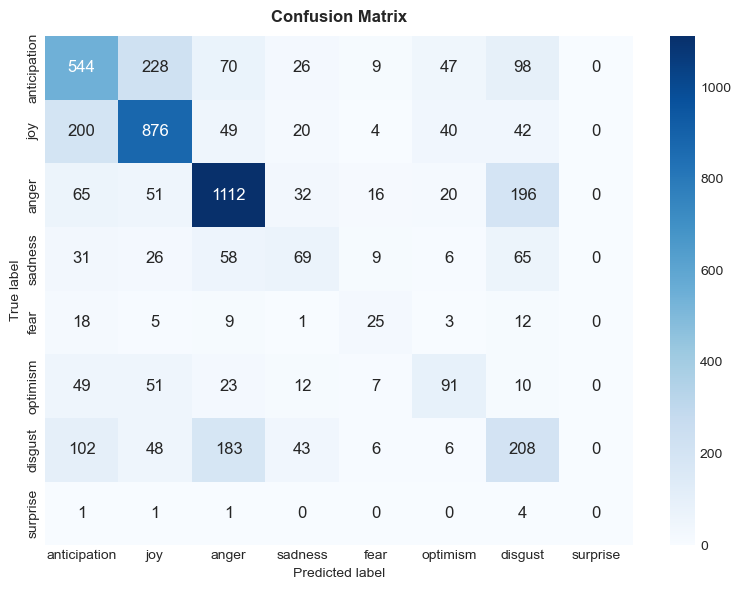

In [47]:
# Calculate confusion matrix
cm = confusion_matrix(y_test_list, y_pred_list)

# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', annot_kws={"size": 12},xticklabels=sentiments, yticklabels=sentiments)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()